In [1]:
%matplotlib inline
import pandas as pd
import caselawnet
import os
import json
from matplotlib import pyplot as plt

[nltk_data] Downloading package punkt to /home/dafne/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Load a network (created with caselawnet):

In [2]:
fn = '/media/sf_VBox_Shared/CaseLaw/graphs/wgaans/paper_30mei2017.json'
with open(fn) as f:
    network = json.load(f)

In [3]:
nodes_df = pd.DataFrame(network['nodes'])
links_df = pd.DataFrame(network['edges'])
print(nodes_df.shape, links_df.shape)

(154, 26) (177, 3)


Create a new network for each year:

In [4]:
networks = {}
for year in range(min(nodes_df['year']), max(nodes_df['year'])+1):
    nodes_filtered_df = nodes_df[nodes_df['year']<=year]
    nodes_filtered = nodes_filtered_df.to_dict(orient='records')
    links_filtered = [l for l in network['edges'] 
                      if l['source'] in nodes_filtered_df['id'].as_matrix()
                     and l['target'] in nodes_filtered_df['id'].as_matrix()]
    if len(links_filtered) > 0:
        nodes_year = caselawnet.network_analysis.add_network_statistics(nodes_filtered.copy(), links_filtered.copy())
        networks[year] = {'nodes': nodes_year, 'edges': links_filtered}

Create one big dataframe with all nodes:

In [5]:
years = list(networks.keys())
years.sort()
nodes_total_df =  pd.concat(
    [pd.DataFrame(networks[year]['nodes']).set_index('ecli') for year in years], keys=years) 

In [6]:
nodes_total_df.columns

Index(['abstract', 'articles', 'authorities', 'betweenness_centrality',
       'closeness_centrality', 'community', 'count_annotation',
       'count_version', 'creator', 'date', 'degree', 'degree_centrality',
       'hubs', 'id', 'in_degree', 'in_degree_centrality', 'out_degree',
       'out_degree_centrality', 'pagerank', 'rel_in_degree', 'subject',
       'title', 'x', 'y', 'year'],
      dtype='object')

Make dataframe with statistics per year:

In [7]:
year_stats = pd.DataFrame(index=years)
year_stats['nr_nodes'] = nodes_total_df.groupby(level=0)['id'].count()
year_stats['nr_links'] = [len(networks[year]['edges']) for year in year_stats.index]
for var in ['in_degree', 'out_degree', 'degree', 
            'in_degree_centrality', 'out_degree_centrality', 'degree_centrality',
           'authorities', 'hubs', 'pagerank', 'betweenness_centrality', 'closeness_centrality', 'rel_in_degree']:
    year_stats['avg_'+var] = nodes_total_df.groupby(level=0)[var].mean()
year_stats.head()

,nr_nodes,nr_links,avg_in_degree,avg_out_degree,avg_degree,avg_in_degree_centrality,avg_out_degree_centrality,avg_degree_centrality,avg_authorities,avg_hubs,avg_pagerank,avg_betweenness_centrality,avg_closeness_centrality,avg_rel_in_degree
1987,9,1,0.111111,0.111111,0.222222,0.013889,0.013889,0.027778,0.111111,0.111111,0.111111,0.000000,0.013889,0.015873
1988,9,1,0.111111,0.111111,0.222222,0.013889,0.013889,0.027778,0.111111,0.111111,0.111111,0.000000,0.013889,0.015873
1989,11,1,0.090909,0.090909,0.181818,0.009091,0.009091,0.018182,0.090909,0.090909,0.090909,0.000000,0.009091,0.010101
1990,15,3,0.200000,0.200000,0.400000,0.014286,0.014286,0.028571,0.066667,0.066667,0.066667,0.000000,0.014286,0.034017
1991,18,5,0.277778,0.277778,0.555556,0.016340,0.016340,0.032680,0.055556,0.055556,0.055556,0.000204,0.017157,0.038830


Plot the size of the network (nr of cases) as a function of the year:

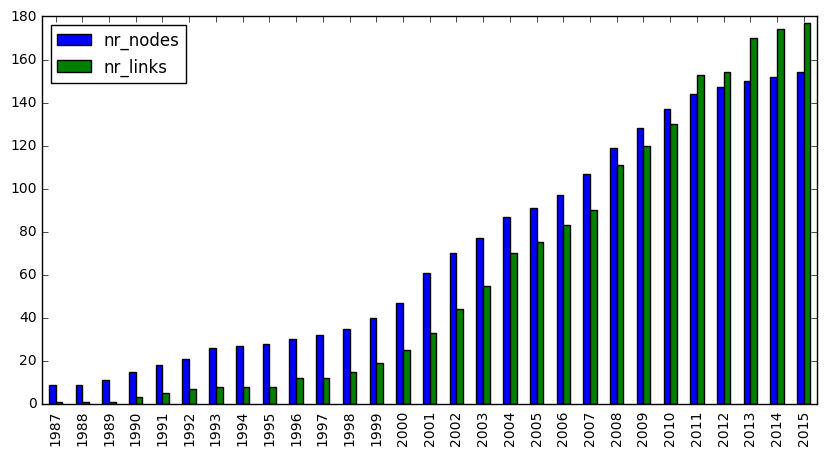

In [8]:
year_stats[['nr_nodes', 'nr_links']].plot(kind='bar', figsize=(10,5))

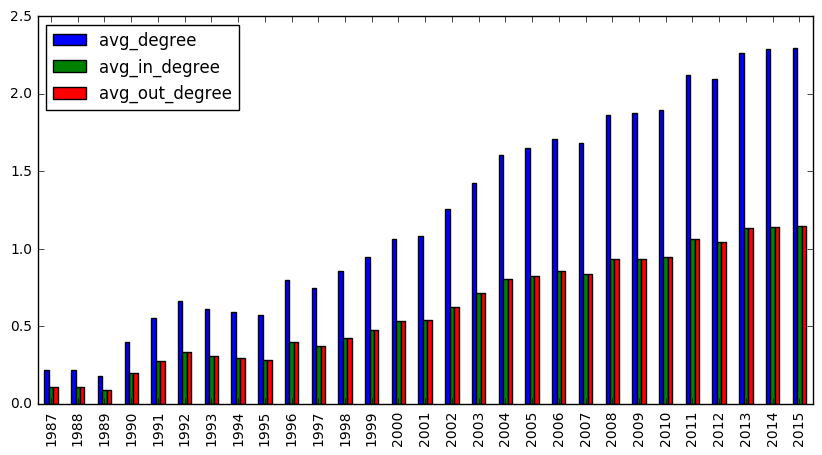

In [9]:
# Plot average nr of links
year_stats[['avg_degree', 'avg_in_degree', 'avg_out_degree']].plot(kind='bar', figsize=(10,5))

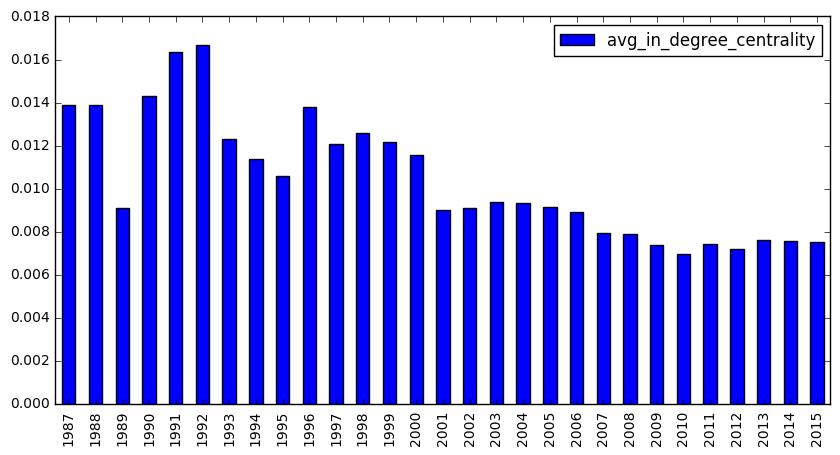

In [18]:
# Plot avg centrality
year_stats[['avg_in_degree_centrality']].plot(kind='bar', figsize=(10,5))

Plot all cases that have an in-degree of at least 2, with their in-degree over time. Both absolute, and relative to the year they were published.

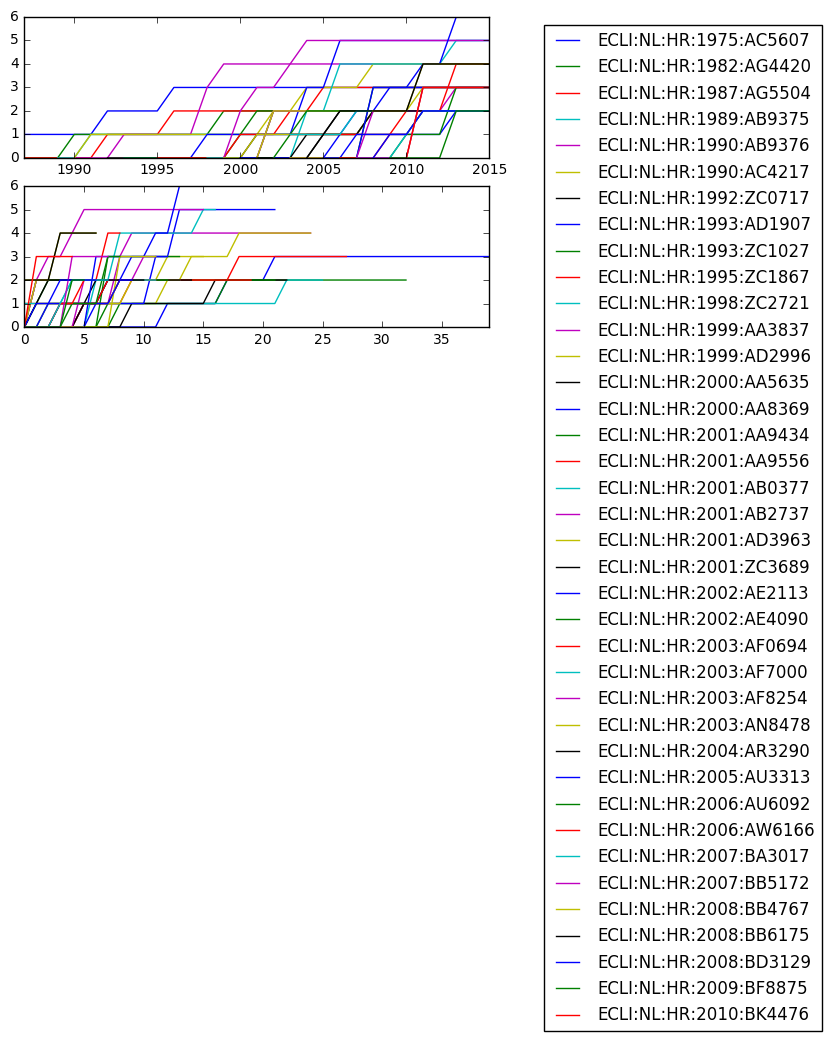

In [10]:
fig, axes = plt.subplots(2, sharex=False)
for ecli in nodes_total_df.index.levels[1]:
    ecli_data = nodes_total_df.xs(ecli, level=1)['in_degree']
    if(max(ecli_data)>1):
        ecli_data.plot(ax=axes[0], label=ecli)
        since_start = ecli_data.copy()
        ecli_year = min(nodes_total_df.xs(ecli, level=1)['year'])
        since_start.index = since_start.index - ecli_year
        since_start = since_start.reindex(range(0, max(since_start.index)), fill_value=0)
        since_start.plot(ax=axes[1], label=ecli)
axes[0].legend(bbox_to_anchor=(1.1, 1), loc='upper left')
plt.show()

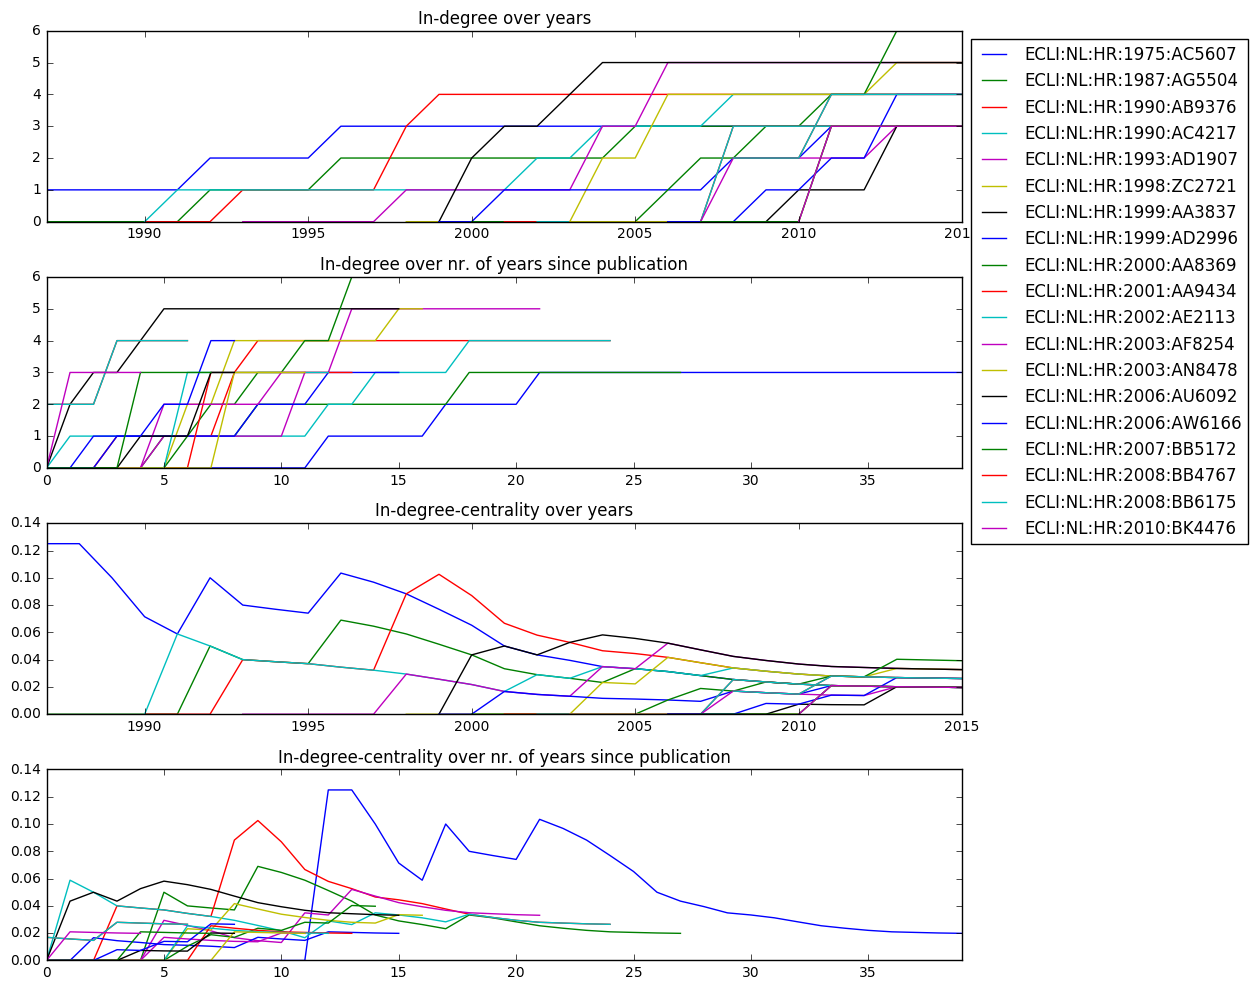

In [80]:
# With in-degree at least 3
fig, axes = plt.subplots(4, figsize=(10, 10))
for ecli in nodes_total_df.index.levels[1]:
    ecli_data = nodes_total_df.xs(ecli, level=1)[['in_degree', 'in_degree_centrality']]
    if(max(ecli_data['in_degree'])>2):
        ecli_data['in_degree'].plot(ax=axes[0], label=ecli)
        ecli_data['in_degree_centrality'].plot(ax=axes[2], label=ecli)
        since_start = ecli_data.copy()
        ecli_year = min(nodes_total_df.xs(ecli, level=1)['year'])
        since_start.index = since_start.index - ecli_year
        since_start = since_start.reindex(range(0, max(since_start.index)), fill_value=0)
        since_start['in_degree'].plot(ax=axes[1], label=ecli)
        since_start['in_degree_centrality'].plot(ax=axes[3], label=ecli)
axes[0].legend(bbox_to_anchor=(1, 1), loc='upper left')
axes[0].set_title('In-degree over years')
axes[1].set_title('In-degree over nr. of years since publication')
axes[2].set_title('In-degree-centrality over years')
axes[3].set_title('In-degree-centrality over nr. of years since publication')
plt.tight_layout()
plt.show()

In [73]:
links_df_merged = links_df.merge(nodes_df[['id', 'ecli', 'year']], 
                          left_on='source', right_on='id', suffixes=['_link', '_source'])
links_df_merged = links_df_merged[['id_link', 'source', 'target', 'ecli', 'year']]
links_df_merged.columns = ['id', 'id_source', 'id_target', 'ecli_source', 'year_source']

links_df_merged = links_df_merged.merge(nodes_df[['id', 'ecli', 'year']], 
                          left_on='id_target', right_on='id', suffixes=['', '_t'])
links_df_merged = links_df_merged[['id', 'id_source', 'id_target', 'ecli_source', 'ecli', 'year_source', 'year']]
links_df_merged.columns = ['id', 'id_source', 'id_target', 'ecli_source', 'ecli_target', 'year_source', 'year_target']

In [74]:
nodes_per_ecli = nodes_total_df.swaplevel().sort_index()

In [75]:
ecli = 'ECLI:NL:HR:1982:AC0442'
links_df_merged[links_df_merged['ecli_target']==ecli]

,id,id_source,id_target,ecli_source,ecli_target,year_source,year_target
98,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,http://deeplink.rechtspraak.nl/uitspraak?id=EC...,ECLI:NL:HR:2015:3019,ECLI:NL:HR:1982:AC0442,2015,1982


In [76]:
nodes_per_ecli.xs(ecli, level=0)['in_degree'].max()

1

In [77]:
max(nodes_df['year'])

2015

In [82]:
nodes_grouped = nodes_per_ecli.groupby(level=0)
links_grouped = links_df_merged.sort_values(['ecli_source', 'ecli_source', 'year_source']).groupby('ecli_target')

ecli_stats = pd.DataFrame(index=nodes_total_df.index.levels[1])
ecli_stats.loc[nodes_grouped.groups, 'max_in_degree'] = (nodes_grouped['in_degree'].max())
ecli_stats.loc[links_grouped.groups, 'first_incoming'] = links_grouped['year_source'].min()
ecli_stats.loc[links_grouped.groups, 'last_incoming'] = links_grouped['year_source'].max()
ecli_stats['first_last_diff'] = ecli_stats['last_incoming'] - ecli_stats['first_incoming']
ecli_stats.head()

,max_in_degree,first_incoming,last_incoming,first_last_diff
ecli,,,,
ECLI:NL:HR:1969:AC4973,1,2010.0,2010.0,0.0
ECLI:NL:HR:1975:AC5607,3,1987.0,1996.0,9.0
ECLI:NL:HR:1976:AC5837,1,2010.0,2010.0,0.0
ECLI:NL:HR:1978:AC3514,1,2005.0,2005.0,0.0
ECLI:NL:HR:1982:AC0442,1,2015.0,2015.0,0.0


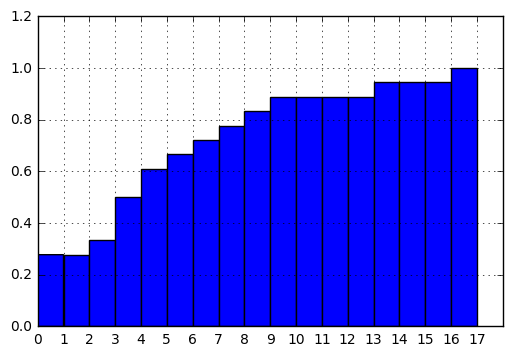

In [100]:
differences = ecli_stats[ecli_stats['max_in_degree']>2]['first_last_diff']
differences.hist(bins=int(max(differences)), cumulative=True, normed=True)
plt.xticks(range(int(max(differences)+1)))
plt.show()

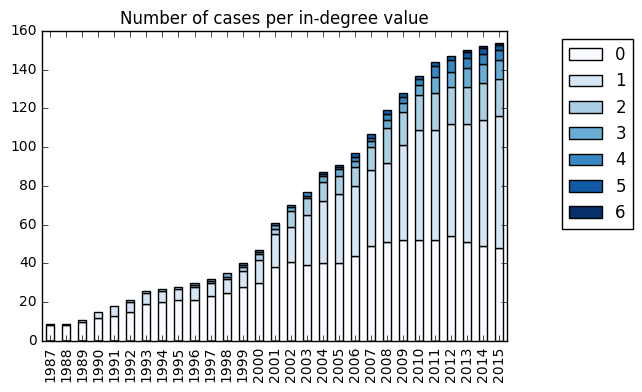

In [67]:
year_indegree_cnts = nodes_total_df.groupby([pd.Grouper(level=0), 'in_degree'])['id'].count()
year_indegree_cnts_pivot = year_indegree_cnts.unstack().fillna(0)
year_indegree_cnts_pivot.plot(kind='bar', stacked=True, cmap='Blues')
plt.title('Number of cases per in-degree value')
plt.legend(bbox_to_anchor=(1.1, 1), loc='upper left')

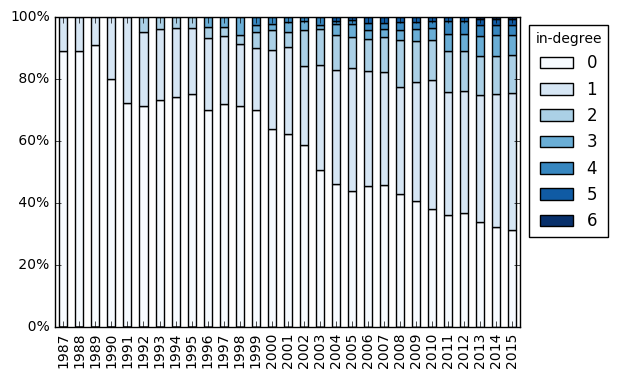

In [78]:
import matplotlib.ticker as ticker
fig, ax = plt.subplots()
year_indegree_cnts2 = year_indegree_cnts_pivot.divide(year_indegree_cnts_pivot.sum(axis=1), axis=0)
year_indegree_cnts2.plot(kind='bar', stacked=True, cmap='Blues', ax=ax)
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in ax.get_yticks()])

plt.title('')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', title='in-degree')

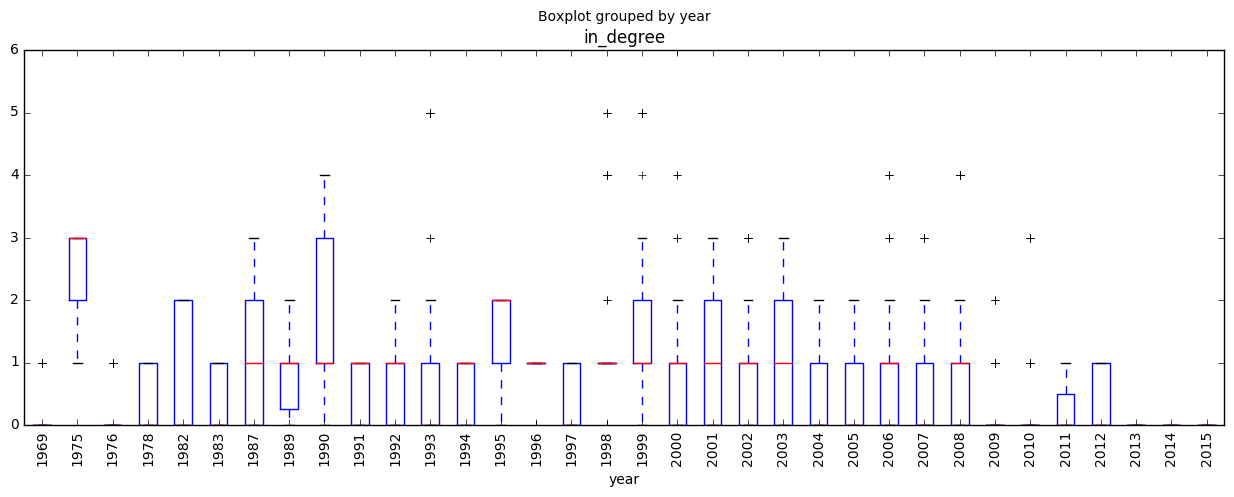

In [27]:
fig, axes = plt.subplots(1, figsize=(15,5))
nodes_total_df.boxplot(column='in_degree', by='year', ax=axes, rot=90, grid=False)

In [25]:
nodes_total_df.boxplot?